In [2]:
# all the imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
import glob
import os
import seaborn as sns
import pickle

In [3]:
# some constant variables
# NUM_CLASSES = 62
IMG_SIZE = 256

K.set_image_data_format('channels_last')

INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [4]:
def create_dataset_lists(path):
    
    class_iter = glob.glob(path)
    
    X = [] # store all images
    y = [] # store all labels
    
    for i in class_iter:
        label = i.split('/')[-1].lstrip('Sample0')
        
        class_images = glob.iglob(os.path.join(i, '*'))
        
        # within this class, append all the images to an array
        for img in class_images:
            image = cv2.imread(img)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            image = img_to_array(image)
            X.append(image)
            y.append(label)

    return (X, y)

In [5]:
X, y = create_dataset_lists('English/*/*/Bmp/*')

print("Length of all data:", len(X))

Length of all data: 12503


In [6]:
# make X and y numpy arrays
X = np.array(X, dtype='float') / 255.0 # normalise to [0,1]
y = np.array(y, dtype='int')

# to_categorical requires the labels to start from 0, not from 1
y = y - 1

# change y to one hot encoding
y = to_categorical(y, num_classes=NUM_CLASSES)

In [7]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

print("Length of training data:", len(X_train))
print("Length of testing data:", len(X_test))

Length of training data: 10002
Length of testing data: 2501


In [8]:
# start making the model now and then train it

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1, patience=3)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = INPUT_SHAPE, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer = 'adadelta', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs=40, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop])


Train on 10002 samples, validate on 2501 samples
Epoch 1/40
10002/10002 [==============================] - 9s 919us/step - loss: 3.8042 - acc: 0.0734 - val_loss: 3.6317 - val_acc: 0.1120
Epoch 2/40
10002/10002 [==============================] - 8s 825us/step - loss: 2.9560 - acc: 0.2716 - val_loss: 2.2938 - val_acc: 0.4634
Epoch 3/40
10002/10002 [==============================] - 8s 828us/step - loss: 2.0124 - acc: 0.4693 - val_loss: 1.5394 - val_acc: 0.5786
Epoch 4/40
10002/10002 [==============================] - 10s 1ms/step - loss: 1.6219 - acc: 0.5571 - val_loss: 1.3077 - val_acc: 0.6393
Epoch 5/40
10002/10002 [==============================] - 8s 823us/step - loss: 1.4193 - acc: 0.6067 - val_loss: 1.1965 - val_acc: 0.6713
Epoch 6/40
10002/10002 [==============================] - 8s 821us/step - loss: 1.2869 - acc: 0.6368 - val_loss: 1.1389 - val_acc: 0.6857
Epoch 7/40
10002/10002 [==============================] - 8s 820us/step - loss: 1.1871 - acc: 0.6632 - val_loss: 1.0322 - va

In [19]:
# save for reproducibility
pickle.dump(X_train, open('X_train.pickle', 'wb'))
pickle.dump(y_train, open('y_train.pickle', 'wb'))
pickle.dump(X_test, open('X_test.pickle', 'wb'))
pickle.dump(y_test, open('y_test.pickle', 'wb'))
model.save('chars74k.h5')

In [20]:
# evaluate the model on the test data
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2501/2501 [==============================] - 1s 268us/step
Test loss: 0.8394632966744332
Test accuracy: 0.7612954818191933


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 128)         0         
__________

Predicted class: 25 | Real class: 25


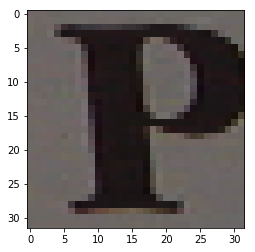

Predicted class: 50 | Real class: 50


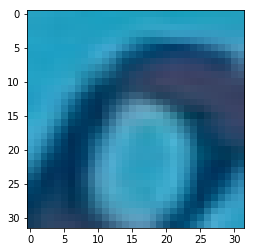

Predicted class: 15 | Real class: 14


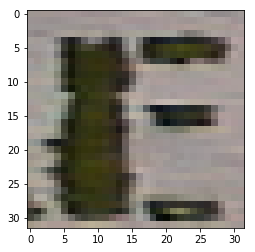

Predicted class: 40 | Real class: 40


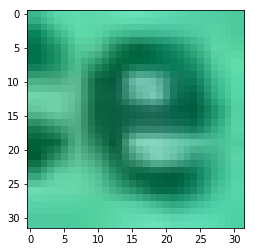

Predicted class: 6 | Real class: 6


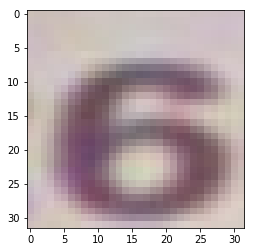

Predicted class: 40 | Real class: 54


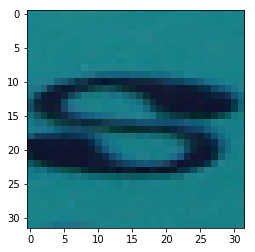

Predicted class: 23 | Real class: 23


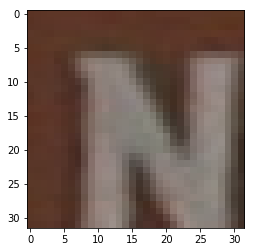

Predicted class: 36 | Real class: 16


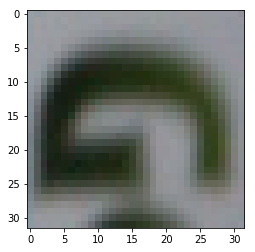

Predicted class: 16 | Real class: 16


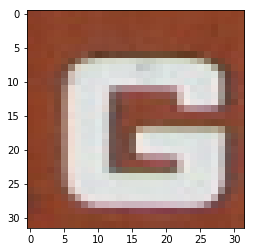

Predicted class: 22 | Real class: 22


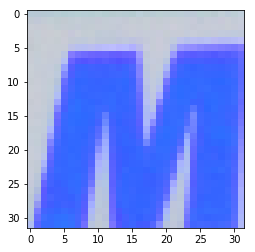

Predicted class: 0 | Real class: 50


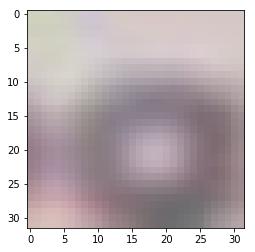

Predicted class: 24 | Real class: 50


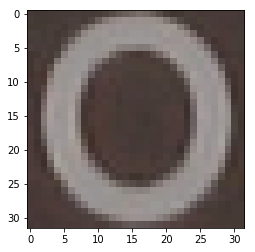

Predicted class: 38 | Real class: 38


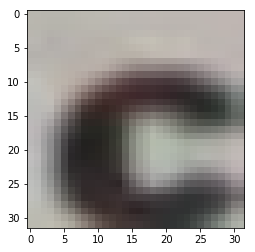

Predicted class: 40 | Real class: 40


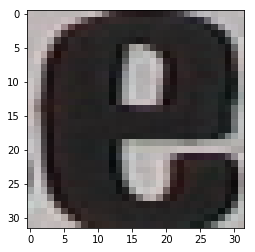

Predicted class: 55 | Real class: 55


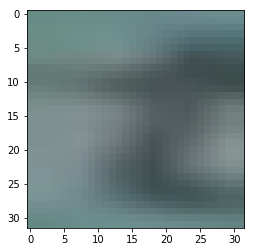

Predicted class: 0 | Real class: 0


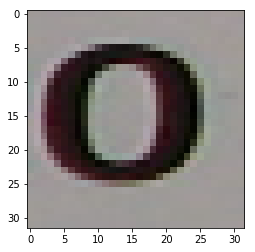

Predicted class: 18 | Real class: 13


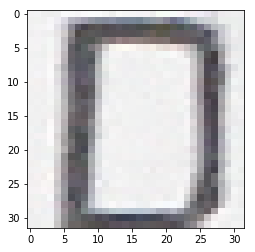

Predicted class: 44 | Real class: 44


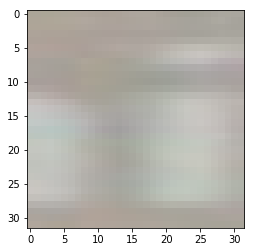

Predicted class: 22 | Real class: 22


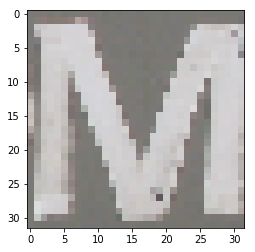

Predicted class: 23 | Real class: 23


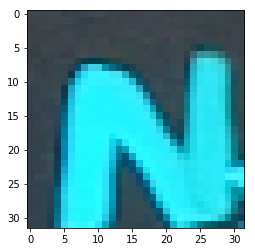

In [22]:
# make predictions
predictions = model.predict_classes(X_test)

# plot predictions for visual confirmation
for i, prediction in enumerate(predictions[:20]):
    print('Predicted class:', prediction, '| Real class:', np.argmax(y_test[i]))
    plt.subplot()
    plt.imshow(X_test[i])
    plt.show()

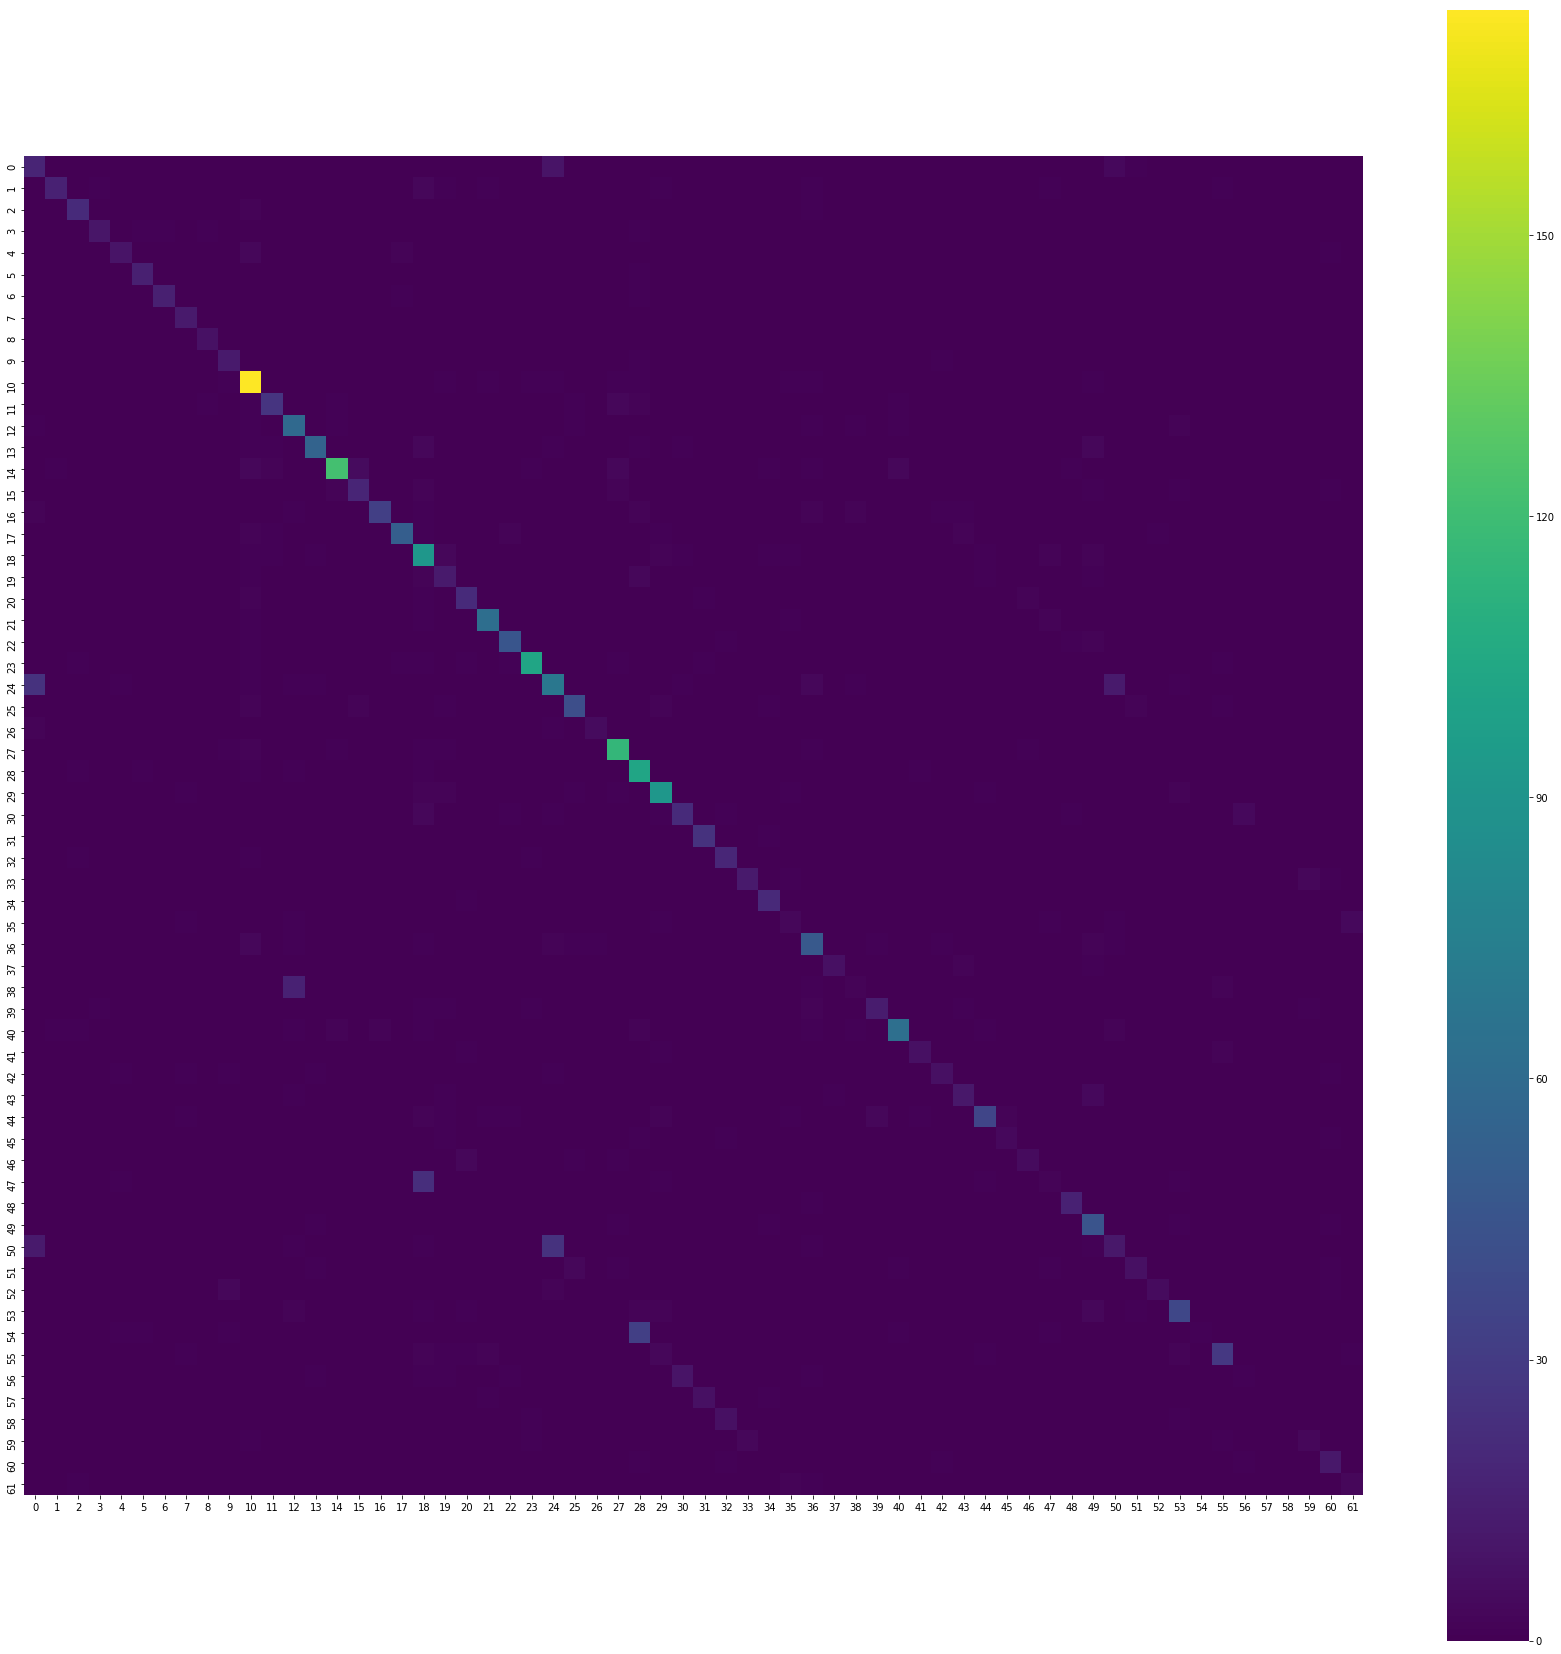

In [23]:
# generate and plot confusion matrix

confusion_mtx = confusion_matrix(np.argmax(y_test, axis = 1), predictions)

plt.figure(figsize=(30,30))
# sns.heatmap(confusion_mtx, square=True, yticklabels=False, xticklabels=False)
sns.heatmap(confusion_mtx, square=True, cmap='viridis')

In [46]:
# get output of the individual layers and plot it
# code copied from: https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X_train])

def display_activation(activations, col_size, row_size, act_index):
#     print("Layer name:", model.layers[act_index].name)
    activation = activations[act_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3.5,col_size))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis')
            activation_index += 1
    plt.suptitle("Layer name: %s" % (model.layers[act_index].name,))

44


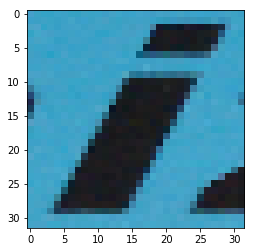

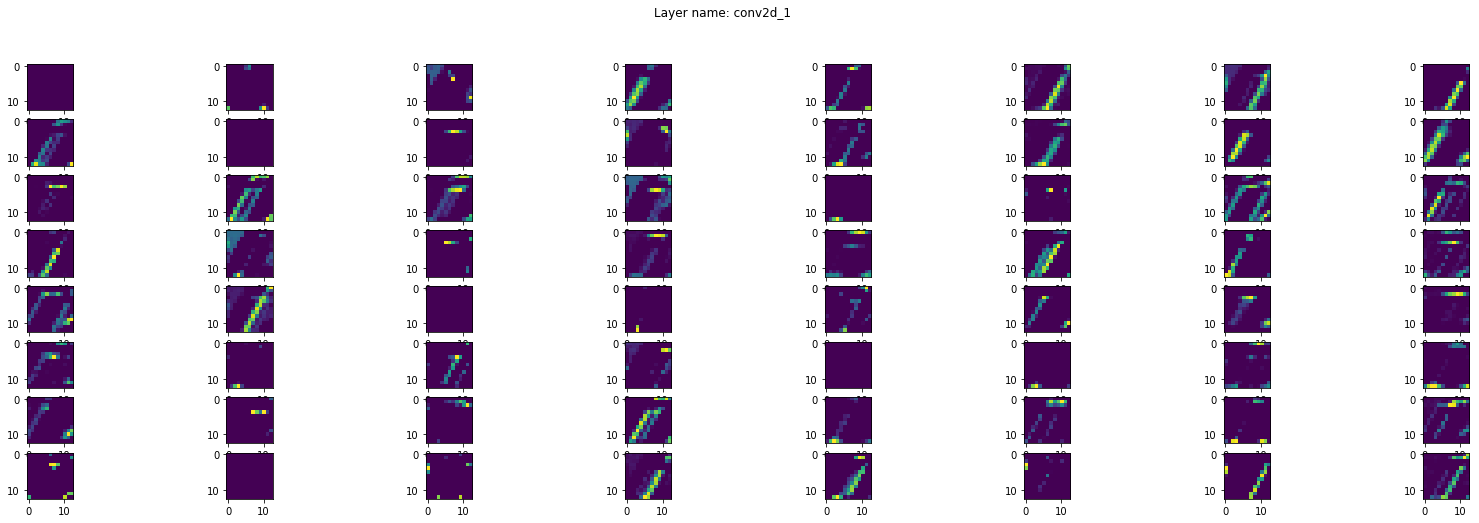

In [51]:
plt.imshow(X_train[0])
print(np.argmax(y_train[0]))
display_activation(activations, 8, 8, 2)

In [ ]:
# for the demo
model = load_model('chars74k.h5')

pickle_in = open('X_train.pickle', 'rb')
X_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open('X_test.pickle', 'rb')
X_test = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open('y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open('y_test.pickle', 'rb')
y_test = pickle.load(pickle_in)
pickle_in.close()